<a href="https://colab.research.google.com/github/RamKishoreKV/Human-Activity-Recognition-ML-for-Data-Science/blob/main/HAR_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install pyspark
!pip install findspark

In [47]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [48]:
!pip install hdfs3

In [49]:
!ls "/content/healthcare-dataset-stroke-data.csv"

/content/healthcare-dataset-stroke-data.csv


In [50]:
from pyspark.sql.functions import isnan, when, count, col,explode, array, lit,rand,monotonically_increasing_id,udf
from pyspark.ml.feature import StringIndexer,VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import IntegerType

In [51]:
spark_df = spark.read.csv('/content/healthcare-dataset-stroke-data.csv', inferSchema=True, header=True)

In [52]:
spark_df.show(5)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [53]:
#Shape of the dataset...
print("Shape: ", (spark_df.count(), len(spark_df.columns)))

Shape:  (5110, 12)


In [54]:
#Info() as pandas....
spark_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [55]:
#Converting the dtype of some variables....
spark_df = spark_df.withColumn("age", spark_df["age"].cast("integer"))
spark_df = spark_df.withColumn("bmi", spark_df["bmi"].cast("integer"))
spark_df = spark_df.withColumn("avg_glucose_level", spark_df["avg_glucose_level"].cast("integer"))

In [56]:
#Basic Statistics.....
spark_df.describe().show(2)

+-------+-----------------+------+-----------------+------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+------------------+
|summary|               id|gender|              age|      hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|            stroke|
+-------+-----------------+------+-----------------+------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+------------------+
|  count|             5110|  5110|             5110|              5110|               5110|        5110|     5110|          5110|              5110|              4909|          5110|              5110|
|   mean|36517.82935420744|  NULL|43.21526418786693|0.0974559686888454|0.05401174168297456|        NULL|     NULL|          NULL|105.65831702544031|28.448563862293746|          NULL|0.04872798

In [57]:
#Statistics on Specific Features...
spark_df.describe(["age", "stroke"]).show() #summary statistics for specific variables

+-------+------------------+-------------------+
|summary|               age|             stroke|
+-------+------------------+-------------------+
|  count|              5110|               5110|
|   mean| 43.21526418786693| 0.0487279843444227|
| stddev|22.633865752854746|0.21531985698023753|
|    min|                 0|                  0|
|    max|                82|                  1|
+-------+------------------+-------------------+



In [58]:
#Using the groupby on variable..
spark_df.groupby("stroke").count().show() #class statistics of categorical variables

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+



In [59]:
spark_df.select("stroke").distinct().show() #unique classes

+------+
|stroke|
+------+
|     1|
|     0|
+------+



In [60]:
spark_df.groupby("Stroke").agg({"age": "mean"}).show()

+------+-----------------+
|Stroke|         avg(age)|
+------+-----------------+
|     1|67.72690763052209|
|     0|41.95967907837893|
+------+-----------------+



In [61]:
#Selection and summary statistics of all categorical variables
cat_cols = [col[0] for col in spark_df.dtypes if col[1] == "string"]
spark_df.select(cat_cols).describe().show()
print("No. Of Categorical Columns:", len(cat_cols) + 1)

+-------+------+------------+---------+--------------+--------------+
|summary|gender|ever_married|work_type|Residence_type|smoking_status|
+-------+------+------------+---------+--------------+--------------+
|  count|  5110|        5110|     5110|          5110|          5110|
|   mean|  NULL|        NULL|     NULL|          NULL|          NULL|
| stddev|  NULL|        NULL|     NULL|          NULL|          NULL|
|    min|Female|          No| Govt_job|         Rural|       Unknown|
|    max| Other|         Yes| children|         Urban|        smokes|
+-------+------+------------+---------+--------------+--------------+

No. Of Categorical Columns: 6


In [62]:
#Selection and summary statistics of all numerical variables
num_cols = [col[0] for col in spark_df.dtypes if col[1] != "string"]
spark_df.select(num_cols).describe().show()
print("No. Of Numerical Columns: ",len(num_cols)+1)

+-------+-----------------+------------------+------------------+-------------------+------------------+------------------+-------------------+
|summary|               id|               age|      hypertension|      heart_disease| avg_glucose_level|               bmi|             stroke|
+-------+-----------------+------------------+------------------+-------------------+------------------+------------------+-------------------+
|  count|             5110|              5110|              5110|               5110|              5110|              4909|               5110|
|   mean|36517.82935420744| 43.21526418786693|0.0974559686888454|0.05401174168297456|105.65831702544031|28.448563862293746| 0.0487279843444227|
| stddev|21161.72162482715|22.633865752854746| 0.296606674233791|0.22606298750336554|45.275290309509536| 7.843833618220339|0.21531985698023753|
|    min|               67|                 0|                 0|                  0|                55|                10|             

In [63]:
# mean of numerical variables relative to the target variable
for col in [col.lower() for col in num_cols]:
    spark_df.groupby("Stroke").agg({col: "mean"}).show()

+------+------------------+
|Stroke|           avg(id)|
+------+------------------+
|     1| 37115.06827309237|
|     0|36487.236371117055|
+------+------------------+

+------+-----------------+
|Stroke|         avg(age)|
+------+-----------------+
|     1|67.72690763052209|
|     0|41.95967907837893|
+------+-----------------+

+------+-------------------+
|Stroke|  avg(hypertension)|
+------+-------------------+
|     1|0.26506024096385544|
|     0|0.08887060275663444|
+------+-------------------+

+------+-------------------+
|Stroke| avg(heart_disease)|
+------+-------------------+
|     1|0.18875502008032127|
|     0|0.04710964822053076|
+------+-------------------+

+------+----------------------+
|Stroke|avg(avg_glucose_level)|
+------+----------------------+
|     1|     132.0441767068273|
|     0|     104.3067270109031|
+------+----------------------+

+------+------------------+
|Stroke|          avg(bmi)|
+------+------------------+
|     1|30.028708133971293|
|     0|28.37

In [74]:
#Checking the missing value again...'
from pyspark.sql.functions import isnan, when, count, col
spark_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spark_df.columns]).show()

+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+-----------+-------+
|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|Blood&Heart|Obesity|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+-----------+-------+
|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|          0|      0|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+-----------+-------+



In [75]:
#Checking the specific summary on the variable...
spark_df.select("bmi").summary("50%","mean").show()

+-------+-----------------+
|summary|              bmi|
+-------+-----------------+
|    50%|               28|
|   mean|28.43091976516634|
+-------+-----------------+



In [76]:
# Assigning missing values in bmi feature based on average bmi of Initials
spark_df = spark_df.na.fill({"bmi" : 28})

In [77]:
#Checking the missing value again...
spark_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spark_df.columns]).show()

+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+-----------+-------+
|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|Blood&Heart|Obesity|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+-----------+-------+
|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|          0|      0|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+-----------+-------+



In [78]:
#Removing redundant features...
spark_df = spark_df.drop("id")
spark_df.show(5)

+------+------+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+
|gender|   age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|Blood&Heart|Obesity|
+------+------+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+
|  Male|OldAge|           0|            1|         Yes|      Private|         Urban|              228| 36|formerly smoked|     1|          0|  8.208|
|Female|OldAge|           0|            0|         Yes|Self-employed|         Rural|              202| 28|   never smoked|     1|          0|  5.656|
|  Male|OldAge|           0|            1|         Yes|      Private|         Rural|              105| 32|   never smoked|     1|          0|   3.36|
|Female|OldAge|           0|            0|         Yes|      Private|         Urban|              17

In [79]:
# Feature generation...
spark_df = spark_df.withColumn('Blood&Heart', spark_df.hypertension * spark_df.heart_disease)
spark_df = spark_df.withColumn('Obesity', spark_df["bmi"] * spark_df["avg_glucose_level"]/1000)

In [80]:
#First look...
spark_df.show(2)

+------+------+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+
|gender|   age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|Blood&Heart|Obesity|
+------+------+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+
|  Male|OldAge|           0|            1|         Yes|      Private|         Urban|              228| 36|formerly smoked|     1|          0|  8.208|
|Female|OldAge|           0|            0|         Yes|Self-employed|         Rural|              202| 28|   never smoked|     1|          0|  5.656|
+------+------+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+
only showing top 2 rows



In [81]:
#converting float values to integer
spark_df = spark_df.withColumn("age", spark_df["age"].cast("integer"))
spark_df = spark_df.withColumn("avg_glucose_level", spark_df["avg_glucose_level"].cast("integer"))
spark_df = spark_df.withColumn("bmi", spark_df["bmi"].cast("integer"))

In [82]:
spark_df.show(2)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|Blood&Heart|Obesity|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+
|  Male|NULL|           0|            1|         Yes|      Private|         Urban|              228| 36|formerly smoked|     1|          0|  8.208|
|Female|NULL|           0|            0|         Yes|Self-employed|         Rural|              202| 28|   never smoked|     1|          0|  5.656|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+
only showing top 2 rows



In [83]:
#Repalcing the values just like case statement in sql....
spark_df=spark_df.withColumn('age',
                    when(spark_df['age'] < 30, "Adult").
                    when((spark_df['age'] > 30) & (spark_df['age'] < 40), "MiddleAge").
                    otherwise("OldAge"))

In [84]:
spark_df.show(2)

+------+------+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+
|gender|   age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|Blood&Heart|Obesity|
+------+------+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+
|  Male|OldAge|           0|            1|         Yes|      Private|         Urban|              228| 36|formerly smoked|     1|          0|  8.208|
|Female|OldAge|           0|            0|         Yes|Self-employed|         Rural|              202| 28|   never smoked|     1|          0|  5.656|
+------+------+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+
only showing top 2 rows



In [85]:
#Converting categorical into Numerical variable...Using Label Encoding technique....
#1.Age---columns
indexer = StringIndexer(inputCol="age", outputCol="age_label")
indexer.fit(spark_df).transform(spark_df).show(5)
temp_sdf = indexer.fit(spark_df).transform(spark_df)
spark_df = temp_sdf.withColumn("age", temp_sdf["age_label"].cast("integer"))

+------+------+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+---------+
|gender|   age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|Blood&Heart|Obesity|age_label|
+------+------+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+---------+
|  Male|OldAge|           0|            1|         Yes|      Private|         Urban|              228| 36|formerly smoked|     1|          0|  8.208|      0.0|
|Female|OldAge|           0|            0|         Yes|Self-employed|         Rural|              202| 28|   never smoked|     1|          0|  5.656|      0.0|
|  Male|OldAge|           0|            1|         Yes|      Private|         Rural|              105| 32|   never smoked|     1|          0|   3.36|      0.0|
|Female|OldAge|           0|            

In [86]:
#2.gender---columns
indexer = StringIndexer(inputCol="gender", outputCol="gender_label")
indexer.fit(spark_df).transform(spark_df).show(5)
temp_sdf = indexer.fit(spark_df).transform(spark_df)
spark_df = temp_sdf.withColumn("gender", temp_sdf["gender_label"].cast("integer"))

+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+---------+------------+
|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|Blood&Heart|Obesity|age_label|gender_label|
+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+---------+------------+
|  Male|  0|           0|            1|         Yes|      Private|         Urban|              228| 36|formerly smoked|     1|          0|  8.208|      0.0|         1.0|
|Female|  0|           0|            0|         Yes|Self-employed|         Rural|              202| 28|   never smoked|     1|          0|  5.656|      0.0|         0.0|
|  Male|  0|           0|            1|         Yes|      Private|         Rural|              105| 32|   never smoked|     1|          0|   3.36|    

In [87]:
#3.ever_married---columns
indexer = StringIndexer(inputCol="ever_married", outputCol="ever_married_label")
indexer.fit(spark_df).transform(spark_df).show(5)
temp_sdf = indexer.fit(spark_df).transform(spark_df)
spark_df = temp_sdf.withColumn("ever_married", temp_sdf["ever_married_label"].cast("integer"))

+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+---------+------------+------------------+
|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|Blood&Heart|Obesity|age_label|gender_label|ever_married_label|
+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+---------+------------+------------------+
|     1|  0|           0|            1|         Yes|      Private|         Urban|              228| 36|formerly smoked|     1|          0|  8.208|      0.0|         1.0|               0.0|
|     0|  0|           0|            0|         Yes|Self-employed|         Rural|              202| 28|   never smoked|     1|          0|  5.656|      0.0|         0.0|               0.0|
|     1|  0|           0|            1|         Yes|   

In [88]:
#4.work_type---columns
indexer = StringIndexer(inputCol="work_type", outputCol="work_type_label")
indexer.fit(spark_df).transform(spark_df).show(5)
temp_sdf = indexer.fit(spark_df).transform(spark_df)
spark_df = temp_sdf.withColumn("work_type", temp_sdf["work_type_label"].cast("integer"))

+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+---------+------------+------------------+---------------+
|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|Blood&Heart|Obesity|age_label|gender_label|ever_married_label|work_type_label|
+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+-----------+-------+---------+------------+------------------+---------------+
|     1|  0|           0|            1|           0|      Private|         Urban|              228| 36|formerly smoked|     1|          0|  8.208|      0.0|         1.0|               0.0|            0.0|
|     0|  0|           0|            0|           0|Self-employed|         Rural|              202| 28|   never smoked|     1|          0|  5.656|      0.0|         0.0|           

In [89]:
#5.smoking_status---columns
indexer = StringIndexer(inputCol="smoking_status", outputCol="smoking_status_label")
indexer.fit(spark_df).transform(spark_df).show(5)
temp_sdf = indexer.fit(spark_df).transform(spark_df)
spark_df = temp_sdf.withColumn("smoking_status", temp_sdf["smoking_status_label"].cast("integer"))

+------+---+------------+-------------+------------+---------+--------------+-----------------+---+---------------+------+-----------+-------+---------+------------+------------------+---------------+--------------------+
|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|Blood&Heart|Obesity|age_label|gender_label|ever_married_label|work_type_label|smoking_status_label|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+---------------+------+-----------+-------+---------+------------+------------------+---------------+--------------------+
|     1|  0|           0|            1|           0|        0|         Urban|              228| 36|formerly smoked|     1|          0|  8.208|      0.0|         1.0|               0.0|            0.0|                 2.0|
|     0|  0|           0|            0|           0|        1|         Rural|              202| 28|   never smok

In [90]:
#6.Residence_type---columns
indexer = StringIndexer(inputCol="Residence_type", outputCol="Residence_type_label")
indexer.fit(spark_df).transform(spark_df).show(5)
temp_sdf = indexer.fit(spark_df).transform(spark_df)
spark_df = temp_sdf.withColumn("Residence_type", temp_sdf["Residence_type_label"].cast("integer"))

+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+-----------+-------+---------+------------+------------------+---------------+--------------------+--------------------+
|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|Blood&Heart|Obesity|age_label|gender_label|ever_married_label|work_type_label|smoking_status_label|Residence_type_label|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+-----------+-------+---------+------------+------------------+---------------+--------------------+--------------------+
|     1|  0|           0|            1|           0|        0|         Urban|              228| 36|             2|     1|          0|  8.208|      0.0|         1.0|               0.0|            0.0|                 2.0|                 0.0|
|     0|  0|           0|       

In [91]:
#Converting the dtype....
spark_df = spark_df.withColumn("age_label", spark_df["age_label"].cast("integer"))
spark_df = spark_df.withColumn("gender_label", spark_df["gender_label"].cast("integer"))
spark_df = spark_df.withColumn("ever_married_label", spark_df["ever_married_label"].cast("integer"))
spark_df = spark_df.withColumn("work_type_label", spark_df["work_type_label"].cast("integer"))
spark_df = spark_df.withColumn("smoking_status_label", spark_df["smoking_status_label"].cast("integer"))
spark_df = spark_df.withColumn("Residence_type_label", spark_df["Residence_type_label"].cast("integer"))

In [92]:
#Dropping the redundant features...
spark_df = spark_df.drop("age","gender","ever_married","work_type","smoking_status","Residence_type")
spark_df.show(2)

+------------+-------------+-----------------+---+------+-----------+-------+---------+------------+------------------+---------------+--------------------+--------------------+
|hypertension|heart_disease|avg_glucose_level|bmi|stroke|Blood&Heart|Obesity|age_label|gender_label|ever_married_label|work_type_label|smoking_status_label|Residence_type_label|
+------------+-------------+-----------------+---+------+-----------+-------+---------+------------+------------------+---------------+--------------------+--------------------+
|           0|            1|              228| 36|     1|          0|  8.208|        0|           1|                 0|              0|                   2|                   0|
|           0|            0|              202| 28|     1|          0|  5.656|        0|           0|                 0|              1|                   0|                   1|
+------------+-------------+-----------------+---+------+-----------+-------+---------+------------+----------

In [93]:
#Check the list of the columns
spark_df.columns


['hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'stroke',
 'Blood&Heart',
 'Obesity',
 'age_label',
 'gender_label',
 'ever_married_label',
 'work_type_label',
 'smoking_status_label',
 'Residence_type_label']

In [94]:
#Rearrangement of the columns...
spark_df=spark_df[["gender_label","age_label","hypertension","heart_disease","ever_married_label","work_type_label","Residence_type_label","avg_glucose_level","bmi","smoking_status_label","stroke"]]

In [95]:
spark_df.show(2)

+------------+---------+------------+-------------+------------------+---------------+--------------------+-----------------+---+--------------------+------+
|gender_label|age_label|hypertension|heart_disease|ever_married_label|work_type_label|Residence_type_label|avg_glucose_level|bmi|smoking_status_label|stroke|
+------------+---------+------------+-------------+------------------+---------------+--------------------+-----------------+---+--------------------+------+
|           1|        0|           0|            1|                 0|              0|                   0|              228| 36|                   2|     1|
|           0|        0|           0|            0|                 0|              1|                   1|              202| 28|                   0|     1|
+------------+---------+------------+-------------+------------------+---------------+--------------------+-----------------+---+--------------------+------+
only showing top 2 rows



Since our dataset has more 0 values ,the ml model would get biased towards 0 label,so to avoid that we are balancing it by finding the ratio and duplicating the rows.

In [96]:
classs = spark_df.groupBy('stroke').count().collect()
majority = max(classs, key=lambda x: x[1])[0]
minority = min(classs, key=lambda x: x[1])[0]
majority_count = max(classs, key=lambda x: x[1])[1]
minority_count = min(classs, key=lambda x: x[1])[1]
ratio = majority_count / minority_count
majority_df = spark_df.filter(col('stroke') == majority)
minority_df = spark_df.filter(col('stroke') == minority)
minority_df_balanced = minority_df.withColumn("dummy", explode(array([lit(x) for x in range(int(ratio))]))).drop('dummy')
balanced_df = majority_df.unionAll(minority_df_balanced)






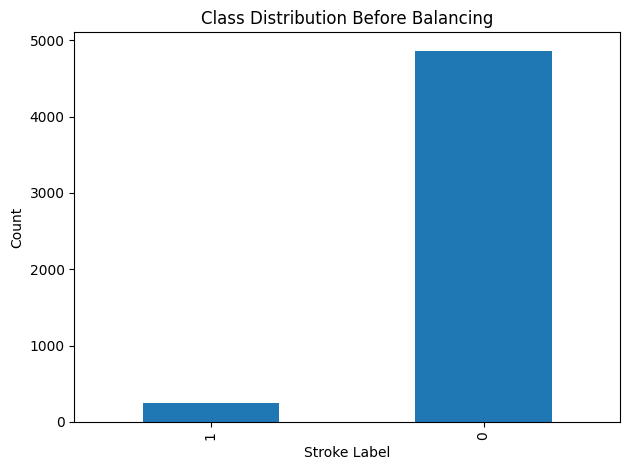

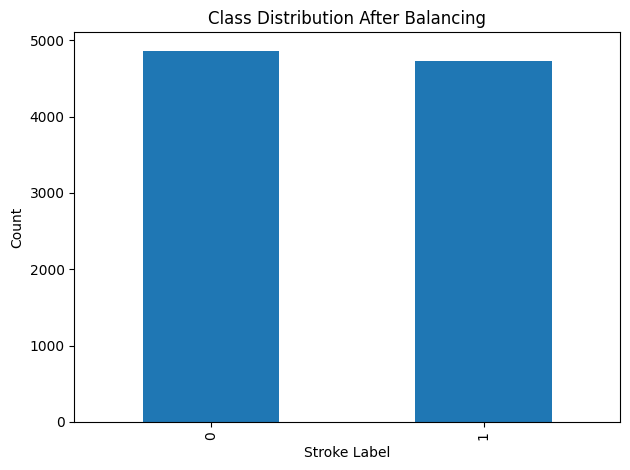

In [97]:
import matplotlib.pyplot as plt
import pandas as pd

# Before balancing
spark_df.groupBy("stroke").count().toPandas().plot(kind='bar', x='stroke', y='count', legend=False)
plt.title("Class Distribution Before Balancing")
plt.xlabel("Stroke Label")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("class_distribution_before.png")
plt.show()

# After balancing
balanced_df.groupBy("stroke").count().toPandas().plot(kind='bar', x='stroke', y='count', legend=False)
plt.title("Class Distribution After Balancing")
plt.xlabel("Stroke Label")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("class_distribution_after.png")
plt.show()


In [115]:
balanced_df = balanced_df.orderBy(rand())
balanced_df.show(5)
unique_values_count = balanced_df.groupby('stroke').count().orderBy('count', ascending=False)
unique_values_count.show()


print("Number of unique values:", unique_values_count)

+------------+---------+------------+-------------+------------------+---------------+--------------------+-----------------+---+--------------------+------+
|gender_label|age_label|hypertension|heart_disease|ever_married_label|work_type_label|Residence_type_label|avg_glucose_level|bmi|smoking_status_label|stroke|
+------------+---------+------------+-------------+------------------+---------------+--------------------+-----------------+---+--------------------+------+
|           1|        0|           0|            0|                 0|              0|                   1|              233| 42|                   0|     1|
|           0|        0|           0|            0|                 1|              2|                   1|              104| 28|                   1|     0|
|           1|        0|           0|            0|                 0|              1|                   0|               77| 27|                   3|     1|
|           0|        0|           0|            0| 

splitting the train and test data
doing vector assembler for creating as a vector for features

In [116]:
(train_data1, test_data1) = spark_df.randomSplit([0.8, 0.2], seed=1)
(train_data2,test_data2)=balanced_df.randomSplit([0.8,0.2],seed=1)
feature_cols = spark_df.columns[:-1]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data1 = assembler.transform(train_data1)
test_data1 = assembler.transform(test_data1)
train_data2 = assembler.transform(train_data2)
test_data2 = assembler.transform(test_data2)





Random Forest Model

In [117]:

rf1 = RandomForestClassifier(labelCol="stroke", featuresCol="features")
rf_model1 = rf1.fit(train_data1)
rf_predictions1 = rf_model1.transform(test_data1)
rf_predictions1.show()


rf2= RandomForestClassifier(labelCol="stroke", featuresCol="features")
rf_model2 = rf2.fit(train_data2)
rf_predictions2 = rf_model2.transform(test_data2)
rf_predictions2.show()

+------------+---------+------------+-------------+------------------+---------------+--------------------+-----------------+---+--------------------+------+--------------------+--------------------+--------------------+----------+
|gender_label|age_label|hypertension|heart_disease|ever_married_label|work_type_label|Residence_type_label|avg_glucose_level|bmi|smoking_status_label|stroke|            features|       rawPrediction|         probability|prediction|
+------------+---------+------------+-------------+------------------+---------------+--------------------+-----------------+---+--------------------+------+--------------------+--------------------+--------------------+----------+
|           0|        0|           0|            0|                 0|              0|                   0|               55| 43|                   0|     0|(10,[7,8],[55.0,4...|[19.0593076598718...|[0.95296538299359...|       0.0|
|           0|        0|           0|            0|                 0|  

Random Forest Model Evaluation

In [118]:
evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
accuracy1 = evaluator.evaluate(rf_predictions1)

print("Original Dataset Evaluation Metrics")
print(f" Accuracy= {accuracy1}")
f11= evaluator.setMetricName("f1").evaluate(rf_predictions1)
precision1 = evaluator.setMetricName("weightedPrecision").evaluate(rf_predictions1)
recall1 = evaluator.setMetricName("weightedRecall").evaluate(rf_predictions1)
print(f"Test F1 Score = {f11}")
print(f"Test Precision = {precision1}")
print(f"Test Recall = {recall1}")
predictionAndLabels1 = rf_predictions1.select("prediction", "stroke").rdd.map(lambda row: (float(row[0]), float(row[1])))
metrics1 = MulticlassMetrics(predictionAndLabels1)
confusion_matrix1 = metrics1.confusionMatrix()
print("Confusion Matrix for original datset:")
print(confusion_matrix1)

print("Balanced Dataset Evaluation Metrics")
accuracy2 = evaluator.evaluate(rf_predictions2)
print(f"Test Accuracy for original dataset= {accuracy2}")
f12= evaluator.setMetricName("f1").evaluate(rf_predictions2)
precision2 = evaluator.setMetricName("weightedPrecision").evaluate(rf_predictions2)
recall2 = evaluator.setMetricName("weightedRecall").evaluate(rf_predictions2)
print(f"Test F1 Score = {f12}")
print(f"Test Precision = {precision2}")
print(f"Test Recall = {recall2}")

predictionAndLabels2 = rf_predictions2.select("prediction", "stroke").rdd.map(lambda row: (float(row[0]), float(row[1])))
metrics2 = MulticlassMetrics(predictionAndLabels2)
confusion_matrix2 = metrics2.confusionMatrix()
print("Confusion Matrix :")
print(confusion_matrix2)



Original Dataset Evaluation Metrics
 Accuracy= 0.9591642924976258
Test F1 Score = 0.9391720168905497
Test Precision = 0.9199961400024711
Test Recall = 0.9591642924976258
Confusion Matrix for original datset:
DenseMatrix([[1010.,    0.],
             [  43.,    0.]])
Balanced Dataset Evaluation Metrics
Test Accuracy for original dataset= 0.7289029535864979
Test F1 Score = 0.7281168817770484
Test Precision = 0.7293331742008313
Test Recall = 0.7289029535864979
Confusion Matrix :
DenseMatrix([[765., 222.],
             [292., 617.]])


Decision Tree

In [119]:
dt = DecisionTreeClassifier(labelCol="stroke", featuresCol="features")
dt_model1 = dt.fit(train_data1)
dt_predictions1 = dt_model1.transform(test_data1)
print("Original Dataset")
dt_predictions1.show()

dt_model2 = dt.fit(train_data2)
dt_predictions2= dt_model2.transform(test_data2)
print("Balanced Dataset")
dt_predictions2.show()

Original Dataset
+------------+---------+------------+-------------+------------------+---------------+--------------------+-----------------+---+--------------------+------+--------------------+--------------+--------------------+----------+
|gender_label|age_label|hypertension|heart_disease|ever_married_label|work_type_label|Residence_type_label|avg_glucose_level|bmi|smoking_status_label|stroke|            features| rawPrediction|         probability|prediction|
+------------+---------+------------+-------------+------------------+---------------+--------------------+-----------------+---+--------------------+------+--------------------+--------------+--------------------+----------+
|           0|        0|           0|            0|                 0|              0|                   0|               55| 43|                   0|     0|(10,[7,8],[55.0,4...|[1988.0,101.0]|[0.95165150789851...|       0.0|
|           0|        0|           0|            0|                 0|         

Decision Tree Model Evaluation

In [120]:
dtpredictions1 = dt_predictions1.select(['prediction', 'stroke']).rdd.map(lambda x: (float(x[0]), float(x[1])))
metricsdt1 = MulticlassMetrics(dtpredictions1)
dtaccuracy1 = metricsdt1.accuracy
dtf11= metricsdt1.weightedFMeasure()

print("Original Dataset")
print(f"Accuracy: {dtaccuracy1}")
print(f"F1:{dtf11}")
print("Decision Tree Confusion Matrix")
print(metricsdt1.confusionMatrix().toArray())


dtpredictions2 = dt_predictions2.select(['prediction', 'stroke']).rdd.map(lambda x: (float(x[0]), float(x[1])))
metricsdt2 = MulticlassMetrics(dtpredictions2)
dtaccuracy2 = metricsdt2.accuracy
dtf12 = metricsdt2.weightedFMeasure()
print("Balanced Dataset")
print(f"Accuracy: {dtaccuracy2}")
print(f"F1:{dtf12}")
print("Decision Tree Confusion Matrix")
print(metricsdt2.confusionMatrix().toArray())


Original Dataset
Accuracy: 0.9572649572649573
F1:0.9415146435772869
Decision Tree Confusion Matrix
[[1006.    4.]
 [  41.    2.]]
Balanced Dataset
Accuracy: 0.7030590717299579
F1:0.7031001828417546
Decision Tree Confusion Matrix
[[702. 285.]
 [278. 631.]]


Logistic Regression


In [121]:
lr = LogisticRegression(labelCol="stroke", featuresCol="features")
lr_model1 = lr.fit(train_data1)
lr_predictions1 = lr_model1.transform(test_data1)
print("Original Dataset")
lr_predictions1.show()

lr_model2 = lr.fit(train_data2)
lr_predictions2 = lr_model2.transform(test_data2)
print("Balanced Datasset")
lr_predictions2.show()


Original Dataset
+------------+---------+------------+-------------+------------------+---------------+--------------------+-----------------+---+--------------------+------+--------------------+--------------------+--------------------+----------+
|gender_label|age_label|hypertension|heart_disease|ever_married_label|work_type_label|Residence_type_label|avg_glucose_level|bmi|smoking_status_label|stroke|            features|       rawPrediction|         probability|prediction|
+------------+---------+------------+-------------+------------------+---------------+--------------------+-----------------+---+--------------------+------+--------------------+--------------------+--------------------+----------+
|           0|        0|           0|            0|                 0|              0|                   0|               55| 43|                   0|     0|(10,[7,8],[55.0,4...|[3.33341447915026...|[0.96555750303817...|       0.0|
|           0|        0|           0|            0|    

Logistic Regression Model Evaluation

In [122]:
lrpredictionsrdd1 = lr_predictions1.select(['prediction', 'stroke']).rdd.map(lambda x: (float(x[0]), float(x[1])))
metricslr1 = MulticlassMetrics(lrpredictionsrdd1)

lraccuracy1 = metricslr1.accuracy
lrf11 = metricslr1.weightedFMeasure()
print("Original Dataset")
print(f"Accuracy: {lraccuracy1}"),
print(f"F1      : {lrf11}")

print("Confusion Matrix")
print(metricslr1.confusionMatrix().toArray())


lrpredictionsrdd2 = lr_predictions2.select(['prediction', 'stroke']).rdd.map(lambda x: (float(x[0]), float(x[1])))
metricslr2 = MulticlassMetrics(lrpredictionsrdd2)

lraccuracy2 = metricslr2.accuracy
lrf12 = metricslr2.weightedFMeasure()
print("Balanced Datset")
print(f"Accuracy: {lraccuracy2}")
print(f"F1      : {lrf12}")

print("Confusion Matrix")
print(metricslr2.confusionMatrix().toArray())

Original Dataset
Accuracy: 0.9591642924976258
F1      : 0.9391720168905497
Confusion Matrix
[[1010.    0.]
 [  43.    0.]]
Balanced Datset
Accuracy: 0.6940928270042194
F1      : 0.6929683497773705
Confusion Matrix
[[738. 249.]
 [331. 578.]]


COMBINING ALL THE ALGORITHMS OUTPUT IN A SINGLE DATAFRAME

In [123]:
rf_predictions_id1 = rf_predictions1.withColumn("row_id", monotonically_increasing_id())
dt_predictions_id1 = dt_predictions1.withColumn("row_id", monotonically_increasing_id())
lr_predictions_id1 = lr_predictions1.withColumn("row_id", monotonically_increasing_id())
rf_predictions_id1 = rf_predictions_id1.withColumnRenamed("prediction", "rf_prediction")
dt_predictions_id1 = dt_predictions_id1.withColumnRenamed("prediction", "dt_prediction")
lr_predictions_id1= lr_predictions_id1.withColumnRenamed("prediction", "lr_prediction")

combined_predictions1 = rf_predictions_id1.join(dt_predictions_id1, "row_id").join(lr_predictions_id1, "row_id")
combined_predictions1= rf_predictions_id1.join(dt_predictions_id1.drop("stroke"), "row_id").join(lr_predictions_id1.drop("stroke"), "row_id")

final_original = combined_predictions1.select("rf_prediction", "dt_prediction", "lr_prediction", "stroke")
print("Original Dataset")
final_original.show()


rf_predictions_id2 = rf_predictions2.withColumn("row_id", monotonically_increasing_id())
dt_predictions_id2= dt_predictions2.withColumn("row_id", monotonically_increasing_id())
lr_predictions_id2 = lr_predictions2.withColumn("row_id", monotonically_increasing_id())
rf_predictions_id2 = rf_predictions_id2.withColumnRenamed("prediction", "rf_prediction")
dt_predictions_id2 = dt_predictions_id2.withColumnRenamed("prediction", "dt_prediction")
lr_predictions_id2= lr_predictions_id2.withColumnRenamed("prediction", "lr_prediction")

combined_predictions2= rf_predictions_id2.join(dt_predictions_id2, "row_id").join(lr_predictions_id2, "row_id")
combined_predictions2= rf_predictions_id2.join(dt_predictions_id2.drop("stroke"), "row_id").join(lr_predictions_id2.drop("stroke"), "row_id")

final_balanced= combined_predictions2.select("rf_prediction", "dt_prediction", "lr_prediction", "stroke")
print("Balanced Dataset")
final_balanced.show()

Original Dataset
+-------------+-------------+-------------+------+
|rf_prediction|dt_prediction|lr_prediction|stroke|
+-------------+-------------+-------------+------+
|          0.0|          0.0|          0.0|     0|
|          0.0|          0.0|          0.0|     0|
|          0.0|          0.0|          0.0|     0|
|          0.0|          0.0|          0.0|     0|
|          0.0|          0.0|          0.0|     0|
|          0.0|          0.0|          0.0|     0|
|          0.0|          0.0|          0.0|     0|
|          0.0|          0.0|          0.0|     0|
|          0.0|          0.0|          0.0|     0|
|          0.0|          0.0|          0.0|     0|
|          0.0|          0.0|          0.0|     0|
|          0.0|          0.0|          0.0|     0|
|          0.0|          0.0|          0.0|     0|
|          0.0|          0.0|          0.0|     0|
|          0.0|          0.0|          0.0|     0|
|          0.0|          0.0|          0.0|     0|
|          0.0

Ensemble:Majority Voting or Hard Voting

In [124]:
def hardvoting(a, b, c):
    zeros = (a == 0) + (b == 0) + (c == 0)
    ones = (a == 1) + (b == 1) + (c == 1)

    if zeros > ones:
        return 0
    elif ones >zeros:
        return 1

hardvotingudf = udf(hardvoting, IntegerType())
final_original = final_original.withColumn("ensemble_prediction",hardvotingudf("rf_prediction", "dt_prediction", "lr_prediction"))
print("Original Dataset")
final_original.show()
final_balanced=final_balanced.withColumn("ensemble_prediction",hardvotingudf("rf_prediction", "dt_prediction", "lr_prediction"))
print("Balanced Dataset")
final_balanced.show()



Original Dataset
+-------------+-------------+-------------+------+-------------------+
|rf_prediction|dt_prediction|lr_prediction|stroke|ensemble_prediction|
+-------------+-------------+-------------+------+-------------------+
|          0.0|          0.0|          0.0|     0|                  0|
|          0.0|          0.0|          0.0|     0|                  0|
|          0.0|          0.0|          0.0|     0|                  0|
|          0.0|          0.0|          0.0|     0|                  0|
|          0.0|          0.0|          0.0|     0|                  0|
|          0.0|          0.0|          0.0|     0|                  0|
|          0.0|          0.0|          0.0|     0|                  0|
|          0.0|          0.0|          0.0|     0|                  0|
|          0.0|          0.0|          0.0|     0|                  0|
|          0.0|          0.0|          0.0|     0|                  0|
|          0.0|          0.0|          0.0|     0|          

Ensemble Evaluation

In [126]:
final_original = final_original.withColumn("ensemble_prediction", col("ensemble_prediction").cast("double"))

evaluator1 = MulticlassClassificationEvaluator(predictionCol="ensemble_prediction", labelCol="stroke", metricName="accuracy")
accuracy_original_ensemble = evaluator1.evaluate(final_original)

print("Accuracy:", accuracy_original_ensemble)  # ✅ fixed this line (was wrongly printing accuracy1)

predictionAndLabels1 = final_original.select("ensemble_prediction", "stroke").rdd.map(lambda row: (float(row[0]), float(row[1])))
metrics = MulticlassMetrics(predictionAndLabels1)
confusion_matrix1 = metrics.confusionMatrix()

print("Confusion Matrix:")
print(confusion_matrix1)

final_balanced = final_balanced.withColumn("ensemble_prediction", col("ensemble_prediction").cast("double"))

evaluator2 = MulticlassClassificationEvaluator(predictionCol="ensemble_prediction", labelCol="stroke", metricName="accuracy")
accuracy_balanced_ensemble = evaluator2.evaluate(final_balanced)

print("Accuracy:", accuracy_balanced_ensemble)  # ✅ fixed this line (was wrongly printing accuracy2)

predictionAndLabels2 = final_balanced.select("ensemble_prediction", "stroke").rdd.map(lambda row: (float(row[0]), float(row[1])))
metrics = MulticlassMetrics(predictionAndLabels2)
confusion_matrix2 = metrics.confusionMatrix()

print("Confusion Matrix:")
print(confusion_matrix2)


Accuracy: 0.9591642924976258
Confusion Matrix:
DenseMatrix([[1010.,    0.],
             [  43.,    0.]])
Accuracy: 0.7304852320675106
Confusion Matrix:
DenseMatrix([[757., 230.],
             [281., 628.]])


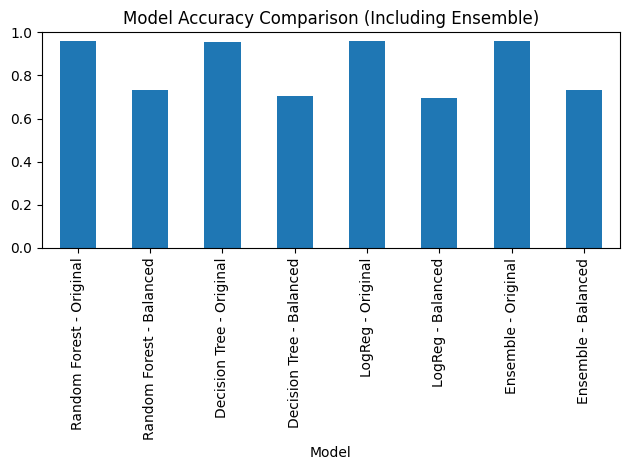

In [127]:
import matplotlib.pyplot as plt
import pandas as pd

accuracy_dict = {
    "Random Forest - Original": accuracy1,
    "Random Forest - Balanced": accuracy2,
    "Decision Tree - Original": dtaccuracy1,
    "Decision Tree - Balanced": dtaccuracy2,
    "LogReg - Original": lraccuracy1,
    "LogReg - Balanced": lraccuracy2,
    "Ensemble - Original": accuracy_original_ensemble,
    "Ensemble - Balanced": accuracy_balanced_ensemble
}

acc_df = pd.DataFrame(list(accuracy_dict.items()), columns=["Model", "Accuracy"])
acc_df.plot(kind="bar", x="Model", y="Accuracy", legend=False)
plt.title("Model Accuracy Comparison (Including Ensemble)")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("accuracy_comparison_ensemble.png")
plt.show()
